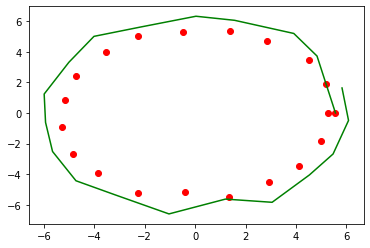

<module 'kalmanFilter_ex' from '/opt/mistsys/ds_incubator/rrm/kalmanFilter_ex.py'>

In [4]:
import matplotlib
import matplotlib.pyplot as plt
#%matplotlib inline  

import kalmanFilter_ex

kalmanFilter_ex

In [3]:
!ls -l 

total 2160
-rw-r--r--  1 wenfengw  wheel  183207 Dec 16 08:52 Site_inactive_hours.ipynb
-rw-r--r--  1 wenfengw  wheel   38029 Dec  5 08:36 Untitled.ipynb
-rw-r--r--  1 wenfengw  wheel  160174 Nov 14 12:53 ap-radio-utilization.ipynb
-rw-r--r--  1 wenfengw  wheel    5829 Oct 28 09:51 ap-scans.ipynb
-rw-r--r--  1 wenfengw  wheel    1341 Nov 19 13:31 ap_util_check.py
-rw-r--r--  1 wenfengw  wheel   21274 Jan 30 10:36 athena-scan-table.ipynb
-rw-r--r--  1 wenfengw  wheel  232154 Feb 20 09:58 coveragehole.ipynb
-rw-r--r--  1 wenfengw  wheel  277280 Nov 14 14:11 radio-utilization_check.ipynb
-rwxr-xr-x  1 wenfengw  wheel   46513 Feb 20 09:56 rrmCmd_kafka.py
-rw-r--r--  1 wenfengw  wheel     544 Feb 20 10:00 rrmES.py
-rw-r--r--  1 wenfengw  wheel   41863 Jan  2 14:36 rssi_util.ipynb
-rw-r--r--  1 wenfengw  wheel    4074 Dec 16 08:52 site_active_time.py
-rw-r--r--  1 wenfengw  wheel    1371 Nov 19 13:31 site_activities.py
-rw-r--r--  1 wenfengw  wheel   38128 Feb 20 09:58 test-neo4j.ipynb
-rw-r

In [2]:
# ------------------------------------------------------------------------
# coding=utf-8
# ------------------------------------------------------------------------
#
#  Created by Martin J. Laubach on 2011-11-15
#
# ------------------------------------------------------------------------

import math
import turtle
import random

turtle.tracer(50000, delay=0)
turtle.register_shape("dot", ((-3,-3), (-3,3), (3,3), (3,-3)))
turtle.register_shape("tri", ((-3, -2), (0, 3), (3, -2), (0, 0)))
turtle.speed(0)
turtle.title("Poor robbie is lost")

UPDATE_EVERY = 0
DRAW_EVERY = 2

class Maze(object):
    def __init__(self, maze):
        self.maze = maze
        self.width   = len(maze[0])
        self.height  = len(maze)
        turtle.setworldcoordinates(0, 0, self.width, self.height)
        self.blocks = []
        self.update_cnt = 0
        self.one_px = float(turtle.window_width()) / float(self.width) / 2

        self.beacons = []
        for y, line in enumerate(self.maze):
            for x, block in enumerate(line):
                if block:
                    nb_y = self.height - y - 1
                    self.blocks.append((x, nb_y))
                    if block == 2:
                        self.beacons.extend(((x, nb_y), (x+1, nb_y), (x, nb_y+1), (x+1, nb_y+1)))

    def draw(self):
        for x, y in self.blocks:
            turtle.up()
            turtle.setposition(x, y)
            turtle.down()
            turtle.setheading(90)
            turtle.begin_fill()
            for _ in range(0, 4):
                turtle.fd(1)
                turtle.right(90)
            turtle.end_fill()
            turtle.up()

        turtle.color("#00ffff")
        for x, y in self.beacons:
            turtle.setposition(x, y)
            turtle.dot()
        turtle.update()

    def weight_to_color(self, weight):
        return "#%02x00%02x" % (int(weight * 255), int((1 - weight) * 255))

    def is_in(self, x, y):
        if x < 0 or y < 0 or x > self.width or y > self.height:
            return False
        return True

    def is_free(self, x, y):
        if not self.is_in(x, y):
            return False

        yy = self.height - int(y) - 1
        xx = int(x)
        return self.maze[yy][xx] == 0

    def show_mean(self, x, y, confident=False):
        if confident:
            turtle.color("#00AA00")
        else:
            turtle.color("#cccccc")
        turtle.setposition(x, y)
        turtle.shape("circle")
        turtle.stamp()

    def show_particles(self, particles):
        self.update_cnt += 1
        if UPDATE_EVERY > 0 and self.update_cnt % UPDATE_EVERY != 1:
            return

        turtle.clearstamps()
        turtle.shape('tri')

        draw_cnt = 0
        px = {}
        for p in particles:
            draw_cnt += 1
            if DRAW_EVERY == 0 or draw_cnt % DRAW_EVERY == 1:
                # Keep track of which positions already have something
                # drawn to speed up display rendering
                scaled_x = int(p.x * self.one_px)
                scaled_y = int(p.y * self.one_px)
                scaled_xy = scaled_x * 10000 + scaled_y
                if not scaled_xy in px:
                    px[scaled_xy] = 1
                    turtle.setposition(*p.xy)
                    turtle.setheading(90 - p.h)
                    turtle.color(self.weight_to_color(p.w))
                    turtle.stamp()

    def show_robot(self, robot):
        turtle.color("green")
        turtle.shape('turtle')
        turtle.setposition(*robot.xy)
        turtle.setheading(90 - robot.h)
        turtle.stamp()
        turtle.update()

    def random_place(self):
        x = random.uniform(0, self.width)
        y = random.uniform(0, self.height)
        return x, y

    def random_free_place(self):
        while True:
            x, y = self.random_place()
            if self.is_free(x, y):
                return x, y

    def distance(self, x1, y1, x2, y2):
        return math.sqrt((x1 - x2) ** 2 + (y1 - y2) ** 2)

    def distance_to_nearest_beacon(self, x, y):
        d = 99999
        for c_x, c_y in self.beacons:
            distance = self.distance(c_x, c_y, x, y)
            if distance < d:
                d = distance
                d_x, d_y = c_x, c_y

        return d

In [3]:
# ------------------------------------------------------------------------
# coding=utf-8
# ------------------------------------------------------------------------
#
#  Created by Martin J. Laubach on 2011-11-15
#
# ------------------------------------------------------------------------

from __future__ import absolute_import

import random
import math
import bisect

#from draw import Maze

"""
# Smaller maze

maze_data = ( ( 2, 0, 1, 0, 0 ),
              ( 0, 0, 0, 0, 1 ),
              ( 1, 1, 1, 0, 0 ),
              ( 1, 0, 0, 0, 0 ),
              ( 0, 0, 2, 0, 1 ))
"""

# 0 - empty square
# 1 - occupied square
# 2 - occupied square with a beacon at each corner, detectable by the robot

maze_data = ( ( 1, 1, 0, 0, 2, 0, 0, 0, 0, 1 ),
              ( 1, 2, 0, 0, 1, 1, 0, 0, 0, 0 ),
              ( 0, 1, 1, 0, 0, 0, 0, 1, 0, 1 ),
              ( 0, 0, 0, 0, 1, 0, 0, 1, 1, 2 ),
              ( 1, 1, 0, 1, 1, 2, 0, 0, 1, 0 ),
              ( 1, 1, 1, 0, 1, 1, 1, 0, 2, 0 ),
              ( 2, 0, 0, 0, 0, 0, 0, 0, 0, 0 ),
              ( 1, 2, 0, 1, 1, 1, 1, 0, 0, 0 ),
              ( 0, 0, 0, 0, 1, 0, 0, 0, 1, 0 ),
              ( 0, 0, 1, 0, 0, 2, 1, 1, 1, 0 ))

PARTICLE_COUNT = 2000    # Total number of particles

ROBOT_HAS_COMPASS = True # Does the robot know where north is? If so, it
# makes orientation a lot easier since it knows which direction it is facing.
# If not -- and that is really fascinating -- the particle filter can work
# out its heading too, it just takes more particles and more time. Try this
# with 3000+ particles, it obviously needs lots more hypotheses as a particle
# now has to correctly match not only the position but also the heading.

# ------------------------------------------------------------------------
# Some utility functions

def add_noise(level, *coords):
    return [x + random.uniform(-level, level) for x in coords]

def add_little_noise(*coords):
    return add_noise(0.02, *coords)

def add_some_noise(*coords):
    return add_noise(0.1, *coords)

# This is just a gaussian kernel I pulled out of my hat, to transform
# values near to robbie's measurement => 1, further away => 0
sigma2 = 0.9 ** 2
def w_gauss(a, b):
    error = a - b
    g = math.e ** -(error ** 2 / (2 * sigma2))
    return g

# ------------------------------------------------------------------------
def compute_mean_point(particles):
    """
    Compute the mean for all particles that have a reasonably good weight.
    This is not part of the particle filter algorithm but rather an
    addition to show the "best belief" for current position.
    """

    m_x, m_y, m_count = 0, 0, 0
    for p in particles:
        m_count += p.w
        m_x += p.x * p.w
        m_y += p.y * p.w

    if m_count == 0:
        return -1, -1, False

    m_x /= m_count
    m_y /= m_count

    # Now compute how good that mean is -- check how many particles
    # actually are in the immediate vicinity
    m_count = 0
    for p in particles:
        if world.distance(p.x, p.y, m_x, m_y) < 1:
            m_count += 1

    return m_x, m_y, m_count > PARTICLE_COUNT * 0.95

# ------------------------------------------------------------------------
class WeightedDistribution(object):
    def __init__(self, state):
        accum = 0.0
        self.state = [p for p in state if p.w > 0]
        self.distribution = []
        for x in self.state:
            accum += x.w
            self.distribution.append(accum)

    def pick(self):
        try:
            return self.state[bisect.bisect_left(self.distribution, random.uniform(0, 1))]
        except IndexError:
            # Happens when all particles are improbable w=0
            return None

# ------------------------------------------------------------------------
class Particle(object):
    def __init__(self, x, y, heading=None, w=1, noisy=False):
        if heading is None:
            heading = random.uniform(0, 360)
        if noisy:
            x, y, heading = add_some_noise(x, y, heading)

        self.x = x
        self.y = y
        self.h = heading
        self.w = w

    def __repr__(self):
        return "(%f, %f, w=%f)" % (self.x, self.y, self.w)

    @property
    def xy(self):
        return self.x, self.y

    @property
    def xyh(self):
        return self.x, self.y, self.h

    @classmethod
    def create_random(cls, count, maze):
        return [cls(*maze.random_free_place()) for _ in range(0, count)]

    def read_sensor(self, maze):
        """
        Find distance to nearest beacon.
        """
        return maze.distance_to_nearest_beacon(*self.xy)

    def advance_by(self, speed, checker=None, noisy=False):
        h = self.h
        if noisy:
            speed, h = add_little_noise(speed, h)
            h += random.uniform(-3, 3) # needs more noise to disperse better
        r = math.radians(h)
        dx = math.sin(r) * speed
        dy = math.cos(r) * speed
        if checker is None or checker(self, dx, dy):
            self.move_by(dx, dy)
            return True
        return False

    def move_by(self, x, y):
        self.x += x
        self.y += y

# ------------------------------------------------------------------------
class Robot(Particle):
    speed = 0.2

    def __init__(self, maze):
        super(Robot, self).__init__(*maze.random_free_place(), heading=90)
        self.chose_random_direction()
        self.step_count = 0

    def chose_random_direction(self):
        heading = random.uniform(0, 360)
        self.h = heading

    def read_sensor(self, maze):
        """
        Poor robot, it's sensors are noisy and pretty strange,
        it only can measure the distance to the nearest beacon(!)
        and is not very accurate at that too!
        """
        return add_little_noise(super(Robot, self).read_sensor(maze))[0]

    def move(self, maze):
        """
        Move the robot. Note that the movement is stochastic too.
        """
        while True:
            self.step_count += 1
            if self.advance_by(self.speed, noisy=True,
                checker=lambda r, dx, dy: maze.is_free(r.x+dx, r.y+dy)):
                break
            # Bumped into something or too long in same direction,
            # chose random new direction
            self.chose_random_direction()

# ------------------------------------------------------------------------

world = Maze(maze_data)
world.draw()

# initial distribution assigns each particle an equal probability
particles = Particle.create_random(PARTICLE_COUNT, world)
robbie = Robot(world)

while True:
    # Read robbie's sensor
    r_d = robbie.read_sensor(world)

    # Update particle weight according to how good every particle matches
    # robbie's sensor reading
    for p in particles:
        if world.is_free(*p.xy):
            p_d = p.read_sensor(world)
            p.w = w_gauss(r_d, p_d)
        else:
            p.w = 0

    # ---------- Try to find current best estimate for display ----------
    m_x, m_y, m_confident = compute_mean_point(particles)

    # ---------- Show current state ----------
    world.show_particles(particles)
    world.show_mean(m_x, m_y, m_confident)
    world.show_robot(robbie)

    # ---------- Shuffle particles ----------
    new_particles = []

    # Normalise weights
    nu = sum(p.w for p in particles)
    if nu:
        for p in particles:
            p.w = p.w / nu

    # create a weighted distribution, for fast picking
    dist = WeightedDistribution(particles)

    for _ in particles:
        p = dist.pick()
        if p is None:  # No pick b/c all totally improbable
            new_particle = Particle.create_random(1, world)[0]
        else:
            new_particle = Particle(p.x, p.y,
                    heading=robbie.h if ROBOT_HAS_COMPASS else p.h,
                    noisy=True)
        new_particles.append(new_particle)

    particles = new_particles

    # ---------- Move things ----------
    old_heading = robbie.h
    robbie.move(world)
    d_h = robbie.h - old_heading

    # Move particles according to my belief of movement (this may
    # be different than the real movement, but it's all I got)
    for p in particles:
        p.h += d_h # in case robot changed heading, swirl particle heading too
        p.advance_by(robbie.speed)

Terminator: 

In [ ]:
def convex_hull(points):
    """Computes the convex hull of a set of 2D points.
 
    Input: an iterable sequence of (x, y) pairs representing the points.
    Output: a list of vertices of the convex hull in counter-clockwise order,
      starting from the vertex with the lexicographically smallest coordinates.
    Implements Andrew's monotone chain algorithm. O(n log n) complexity.
    """
 
    # Sort the points lexicographically (tuples are compared lexicographically).
    # Remove duplicates to detect the case we have just one unique point.
    points = sorted(set(points))
 
    # Boring case: no points or a single point, possibly repeated multiple times.
    if len(points) <= 1:
        return points
 
    # 2D cross product of OA and OB vectors, i.e. z-component of their 3D cross product.
    # Returns a positive value, if OAB makes a counter-clockwise turn,
    # negative for clockwise turn, and zero if the points are collinear.
    def cross(o, a, b):
        return (a[0] - o[0]) * (b[1] - o[1]) - (a[1] - o[1]) * (b[0] - o[0])
 
    # Build lower hull 
    lower = []
    for p in points:
        #print lower, p, "  angle ",
        #if len(lower)>=2: print cross(lower[-2], lower[-1], p)
        while len(lower) >= 2 and cross(lower[-2], lower[-1], p) <= 0:
            lower.pop()
        lower.append(p)
        
 
    # Build upper hull
    upper = []
    for p in reversed(points):
        while len(upper) >= 2 and cross(upper[-2], upper[-1], p) <= 0:
            upper.pop()
        upper.append(p)

 
    # Concatenation of the lower and upper hulls gives the convex hull.
    # Last point of each list is omitted because it is repeated at the beginning of the other list. 
    return lower[:-1] + upper[:-1]
 
 
# Example: convex hull of a 10-by-10 grid.
assert convex_hull([(i/10, i%10) for i in range(100)]) == [(0, 0), (9, 0), (9, 9), (0, 9)]

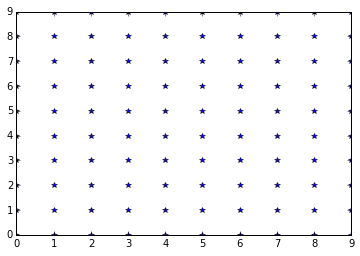

In [87]:
a= zip(* [(i/10, i%10) for i in range(100)])
plt.plot(a[0], a[1], "*")

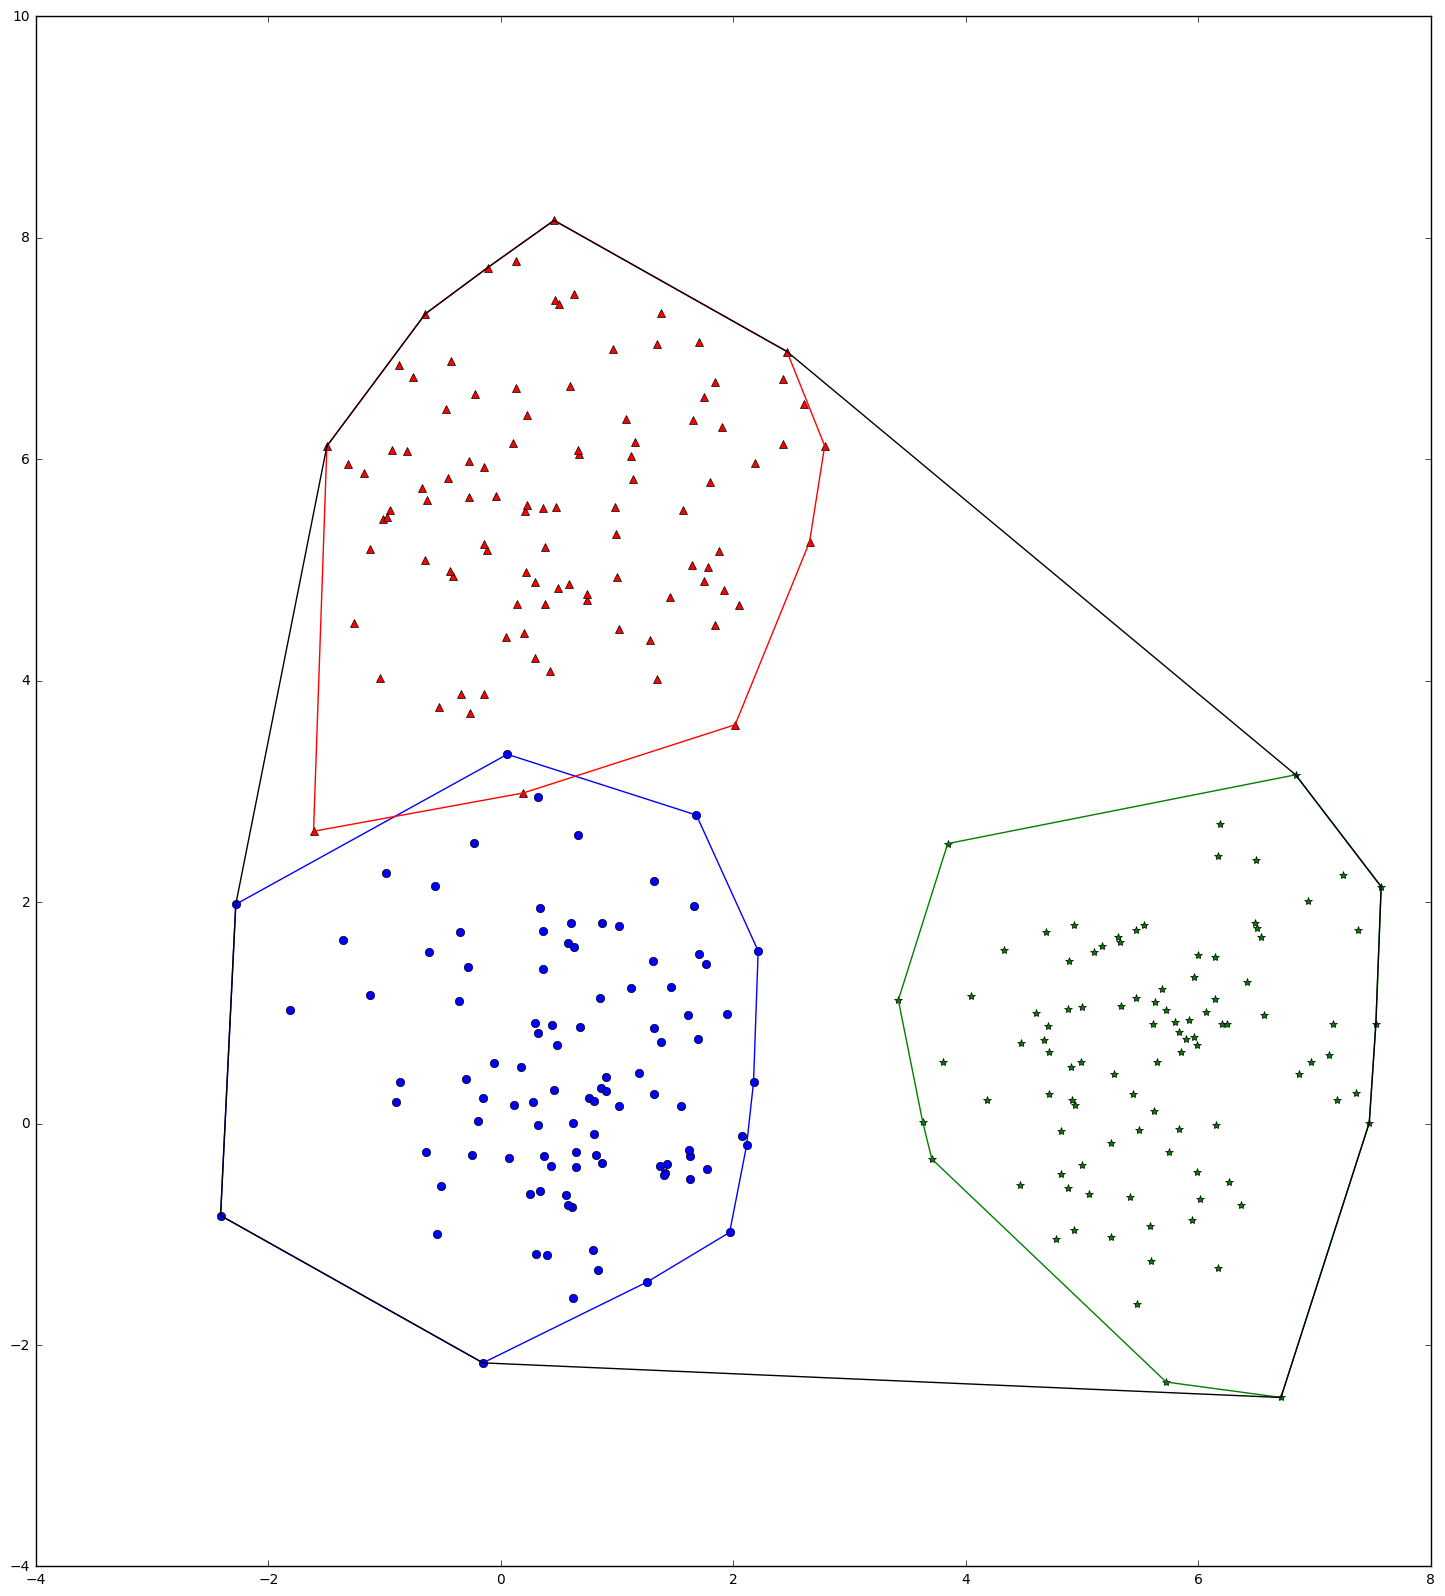

In [4]:
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline  


import numpy as np
from scipy.spatial import ConvexHull


def randomCircle(N, mean=[0, 0]):
    cov = [[1, 0], [0, 1]] # diagonal covariance, points lie on x or y-axis
    points = np.random.multivariate_normal(mean, cov, N).T
    return np.array(zip(*points))
    
    
N = 100
points1 = randomCircle(N, [0.5, 0.5]) #np.random.rand(N, 2)
points2 = randomCircle(N, [5.5, 0.5]) #np.random.rand(N, 2)+ [0, 1.]
points3 = randomCircle(N, [0.5, 5.5]) #np.random.rand(N, 2)+ [1, 0.]

#points1 = randomCircle(N, [0.5, 0.5]) #np.random.rand(N, 2)
#points2 = np.random.rand(N, 2)+ [0, 1.]
#points3 = np.random.rand(N, 2)+ [1, 0.]

plt.figure(figsize=(18, 20))

import matplotlib.pylab as plt
plt.plot(points1[:,0], points1[:, 1], 'o')
plt.plot(points2[:,0], points2[:, 1], '*')
plt.plot(points3[:,0], points3[:, 1], '^')


hull1 = ConvexHull(points1)
hull2 = ConvexHull(points2)
hull3 = ConvexHull(points3)


for simplex in hull1.simplices:
    plt.plot(points1[simplex, 0], points1[simplex, 1], 'b-')

for simplex in hull2.simplices:
    plt.plot(points2[simplex, 0], points2[simplex, 1], 'g-')
    
for simplex in hull3.simplices:
    plt.plot(points3[simplex, 0], points3[simplex, 1], 'r-')


points0 = np.concatenate((points1,points2, points3),axis = 0)
hull0 = ConvexHull( points0)
for simplex in hull0.simplices:
    plt.plot(points0[simplex, 0], points0[simplex, 1], 'k-')



In [43]:
np.shape(np.concatenate((points1,points2, points3),axis =0)) 

(300, 2)

In [7]:
a=randomCircle(1, [0.5, 0.5])


0.2262675829323702